# Coursera capstone project

This jupyter notebook is created for the development of the coursera capstone project


## Import libraries

In [1]:
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans


In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Open a Gym on the Neighborhoods in Toronto

## Part 1: Prepare the data, use of Foursquare

First, we have to import the libraries that we will use for web scrapping, such as Beatiful Soup, and the Folium library for map representations

In [3]:
import requests
from bs4 import BeautifulSoup
#!pip install folium
import folium # map rendering library



We have to obtain the data of the postal codes, we will use the data from Wikipedia

In [4]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

# read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))

In [5]:
# Web Scraping the data from wikipedia page of Toronto postal codes
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        # here we replace some symbols like "(" , ")" , "/" from the neighborhood name(Ex: (Parkview Hill / Woodbine Gardens))
        table_contents.append(cell)

df=pd.DataFrame(table_contents)

# Reduce some names by smallers ones
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [6]:
df.shape

(103, 3)

We have 103 rows in our dataset, with 3 columns. Lets check if we have some missing values

In [7]:
# check for missing value
df.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [8]:
# Check if we still have any Neighborhoods that are Not Assigned
df.loc[df['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []


Now data is cleaned, we dont have any missing values or any Not assigned rows. The next step is to add the Latitude and Longitudes of each location. This is a necessary step before using the Foursquare location data, because Foursquare will use that information


## Retrieve geographical coordinates using Geocoder

In [9]:
# Obtain latitude and the longitude coordinates of each Postal code
url_coord = "https://cocl.us/Geospatial_data"
coord_df = pd.read_csv(url_coord)
coord_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
coord_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [10]:
# Merge with the main dataset
df = pd.merge(df, coord_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

Now, we are gonna make a copy of the dataframe

In [11]:
df_toronto = df
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [12]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

In [13]:
# Obtain the Latitude and Longitude of Toronto by taking the mean value of Latitude/Longitude
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [14]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [15]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

Now we are gonna use Foursquare to look for venues

In [16]:
CLIENT_ID = 'M5VXELSXFDLKWWEQHUMQ3F4V5WX2TVWPJXULTQQ1NHRSTGKQ' # your Foursquare ID
CLIENT_SECRET = 'OA2GBIR0U32YDDZ3GN3IIGZ3JMBZ0RIOFC15VMKQY2JGSONC' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

Now, let's get the top 100 venues that are in Lawrence Park within a radius of 300 meters.

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 1000 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

Unique venues in all the neighborhoods?

In [19]:
print('We can find {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

We can find 330 uniques vanue categories.


In [20]:
toronto_venues['Venue Category'].unique()

array(['Caribbean Restaurant', 'Park', 'Café', 'Grocery Store',
       'Fast Food Restaurant', 'Supermarket', 'Fish & Chips Shop',
       'Pharmacy', 'Pizza Place', 'Food & Drink Shop', 'Intersection',
       'Bus Stop', 'Train Station', 'Discount Store', 'Laundry Service',
       'ATM', 'Chinese Restaurant', 'Coffee Shop', 'Convenience Store',
       'Shopping Mall', 'Skating Rink', 'Tennis Court', 'Cosmetics Shop',
       'Shop & Service', 'Hockey Arena', 'Portuguese Restaurant',
       'French Restaurant', 'Golf Course', 'Sporting Goods Shop',
       "Men's Store", 'Lounge', 'Gym / Fitness Center', 'Bakery',
       'Distribution Center', 'Restaurant', 'Historic Site',
       'Farmers Market', 'Chocolate Shop', 'Performing Arts Venue', 'Pub',
       'Mediterranean Restaurant', 'Dessert Shop', 'Italian Restaurant',
       'Spa', 'Breakfast Spot', 'Theater', 'Mexican Restaurant',
       'Liquor Store', 'Tech Startup', 'Event Space', 'Thai Restaurant',
       'Animal Shelter', 'Yoga Stu

## Part 2: Data analysis

As the column "Venue Category" contain categorical value.So we need to convert it to numerical values using the dummies function

In [21]:
dummies = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood information to our dataframe
dummies['Neighborhoods'] = toronto_venues['Neighborhood'] 

# Place neighborhood column in the first place to make easier the visualization
fixed_columns = [dummies.columns[-1]] + list(dummies.columns[:-1])
dummies = dummies[fixed_columns]

dummies.head()

Neighborhoods  ATM  Accessories Store  Afghan Restaurant  \
0     Parkwoods    0                  0                  0   
1     Parkwoods    0                  0                  0   
2     Parkwoods    0                  0                  0   
3     Parkwoods    0                  0                  0   
4     Parkwoods    0                  0                  0   

   African Restaurant  Airport  American Restaurant  Amphitheater  \
0                   0        0                    0             0   
1                   0        0                    0             0   
2                   0        0                    0             0   
3                   0        0                    0             0   
4                   0        0                    0             0   

   Animal Shelter  Antique Shop  ...  Vietnamese Restaurant  Warehouse Store  \
0               0             0  ...                      0                0   
1               0             0  ...                      0                0   
2               0             0  ...                      0                0   
3               0             0  ...                      0                0   
4               0             0  ...                      0                0   

   Waste Facility  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0               0           0         0          0            0   
1               0           0         0          0            0   
2               0           0         0          0            0   
3               0           0         0          0            0   
4               0           0         0          0            0   

   Women's Store  Yoga Studio  Zoo  
0              0            0    0  
1              0            0    0  
2              0            0    0  
3              0            0    0  
4              0            0    0  

[5 rows x 331 columns]

In [22]:
grouped = dummies.groupby(["Neighborhoods"]).mean().reset_index() 

grouped.head()

Neighborhoods  ATM  Accessories Store  \
0                                        Agincourt  0.0                0.0   
1                           Alderwood, Long Branch  0.0                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North  0.0                0.0   
3                                  Bayview Village  0.0                0.0   
4                Bedford Park, Lawrence Manor East  0.0                0.0   

   Afghan Restaurant  African Restaurant  Airport  American Restaurant  \
0                0.0                 0.0      0.0             0.021739   
1                0.0                 0.0      0.0             0.000000   
2                0.0                 0.0      0.0             0.000000   
3                0.0                 0.0      0.0             0.000000   
4                0.0                 0.0      0.0             0.023810   

   Amphitheater  Animal Shelter  Antique Shop  ...  Vietnamese Restaurant  \
0           0.0             0.0           0.0  ...                    0.0   
1           0.0             0.0           0.0  ...                    0.0   
2           0.0             0.0           0.0  ...                    0.0   
3           0.0             0.0           0.0  ...                    0.0   
4           0.0             0.0           0.0  ...                    0.0   

   Warehouse Store  Waste Facility  Whisky Bar  Wine Bar  Wine Shop  \
0              0.0             0.0         0.0       0.0        0.0   
1              0.0             0.0         0.0       0.0        0.0   
2              0.0             0.0         0.0       0.0        0.0   
3              0.0             0.0         0.0       0.0        0.0   
4              0.0             0.0         0.0       0.0        0.0   

   Wings Joint  Women's Store  Yoga Studio  Zoo  
0      0.00000            0.0          0.0  0.0  
1      0.00000            0.0          0.0  0.0  
2      0.00000            0.0          0.0  0.0  
3      0.00000            0.0          0.0  0.0  
4      0.02381            0.0          0.0  0.0  

[5 rows x 331 columns]

In [23]:
gym = grouped[["Neighborhoods","Gym"]]
gym

Neighborhoods       Gym
0                                          Agincourt  0.000000
1                             Alderwood, Long Branch  0.040000
2    Bathurst Manor, Wilson Heights, Downsview North  0.000000
3                                    Bayview Village  0.000000
4                  Bedford Park, Lawrence Manor East  0.000000
..                                               ...       ...
97                           Willowdale, Newtonbrook  0.000000
98                                            Woburn  0.000000
99                                  Woodbine Heights  0.000000
100                                  York Mills West  0.055556
101                         York Mills, Silver Hills  0.000000

[102 rows x 2 columns]

In [24]:
gym = gym.rename(columns={'Neighborhoods':'Neighborhood'})

### Clustering
We will use k-means clustering. But first we will find the best _K_ value using the **Elbow Point** method.

In [25]:
# Drop "Neighborhood" column
X = gym.drop(['Neighborhood'], axis=1)
X

Gym
0    0.000000
1    0.040000
2    0.000000
3    0.000000
4    0.000000
..        ...
97   0.000000
98   0.000000
99   0.000000
100  0.055556
101  0.000000

[102 rows x 1 columns]

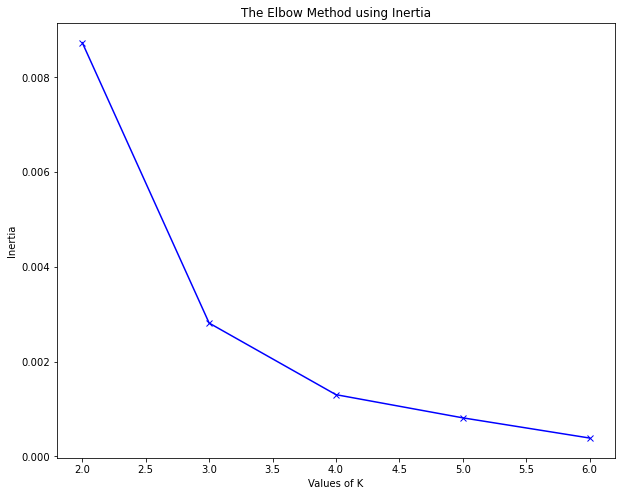

In [26]:
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,7)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Here we can see the the most optimal value for k is 3, so we will have our data grouped in 3 clusters.

In [27]:
kclusters = 4

toronto_grouped_clustering = gym.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 1, 1, 0, 3, 2, 1, 1])

In [28]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = gym.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [29]:
to_merged.head()

Neighborhood   Gym  Cluster Labels
0                                        Agincourt  0.00               1
1                           Alderwood, Long Branch  0.04               0
2  Bathurst Manor, Wilson Heights, Downsview North  0.00               1
3                                  Bayview Village  0.00               1
4                Bedford Park, Lawrence Manor East  0.00               1

In [30]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(4895, 9)


Neighborhood  Gym  Cluster Labels  Neighborhood Latitude  \
0    Agincourt  0.0               1                43.7942   
0    Agincourt  0.0               1                43.7942   
0    Agincourt  0.0               1                43.7942   
0    Agincourt  0.0               1                43.7942   
0    Agincourt  0.0               1                43.7942   

   Neighborhood Longitude                                      Venue  \
0              -79.262029                                Mona's Roti   
0              -79.262029                               The Roti Hut   
0              -79.262029                Panagio's Breakfast & Lunch   
0              -79.262029                   Babu Catering & Take Out   
0              -79.262029  Grandeur Palace 華丽宮 (Grandeur Palace 華麗宮)   

   Venue Latitude  Venue Longitude         Venue Category  
0       43.791613       -79.251015   Caribbean Restaurant  
0       43.787277       -79.258724   Caribbean Restaurant  
0       43.792370       -79.260203         Breakfast Spot  
0       43.791721       -79.251132  Sri Lankan Restaurant  
0       43.797885       -79.270585     Chinese Restaurant

In [31]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

(4895, 9)


Neighborhood       Gym  Cluster Labels  Neighborhood Latitude  \
21  Don Mills North  0.033333               0              43.745906   
18       Davisville  0.030000               0              43.704324   
18       Davisville  0.030000               0              43.704324   
18       Davisville  0.030000               0              43.704324   
18       Davisville  0.030000               0              43.704324   

    Neighborhood Longitude                                              Venue  \
21              -79.352188                                          Mr. Greek   
18              -79.388790  GoodLife Fitness Toronto Mount Pleasant and Da...   
18              -79.388790                                           Positano   
18              -79.388790                                         Flaky Tart   
18              -79.388790                               Florentia Ristorante   

    Venue Latitude  Venue Longitude      Venue Category  
21       43.754386       -79.351690    Greek Restaurant  
18       43.700802       -79.386417                 Gym  
18       43.704558       -79.388639  Italian Restaurant  
18       43.706539       -79.389611        Dessert Shop  
18       43.703594       -79.387985  Italian Restaurant

In [32]:
to_merged['Venue Category'].value_counts()['Gym']

72

We see that there are a total of 72 locations with Gyms in Toronto
We will create a new dataframe with the Neighborhood and gyms

# Visualize Clustering on Google Map

In [33]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

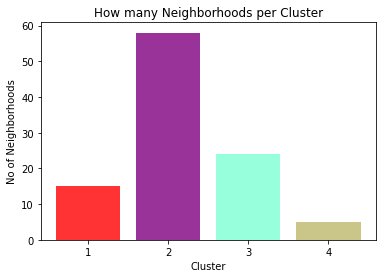

In [34]:
gym["Cluster Labels"] = kmeans.labels_

objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = gym['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [35]:
# How many neighborhoods in each cluster
gym['Cluster Labels'].value_counts()

1    58
2    24
0    15
3     5
Name: Cluster Labels, dtype: int64

## 6.3. Analysis of each Cluster

In [36]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')


In [37]:
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()


Borough Neighborhood  Gym  Cluster Labels  Neighborhood Latitude  \
0  North York    Parkwoods  0.0               1              43.753259   
1  North York    Parkwoods  0.0               1              43.753259   
2  North York    Parkwoods  0.0               1              43.753259   
3  North York    Parkwoods  0.0               1              43.753259   
4  North York    Parkwoods  0.0               1              43.753259   

   Neighborhood Longitude                            Venue  Venue Latitude  \
0              -79.329656           Parkwoods Coin Laundry       43.760386   
1              -79.329656                 Family Food Fair       43.760422   
2              -79.329656              Spicy Chicken House       43.760639   
3              -79.329656                         La Notre       43.760704   
4              -79.329656  Underhill Mini Mart Convenience       43.745836   

   Venue Longitude      Venue Category  
0       -79.324894     Laundry Service  
1       -79.325012                 ATM  
2       -79.325671  Chinese Restaurant  
3       -79.325396         Coffee Shop  
4       -79.324835   Convenience Store

In [38]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()



Borough                   Neighborhood   Gym  Cluster Labels  \
0  Queen's Park  Ontario Provincial Government  0.01               2   
1  Queen's Park  Ontario Provincial Government  0.01               2   
2  Queen's Park  Ontario Provincial Government  0.01               2   
3  Queen's Park  Ontario Provincial Government  0.01               2   
4  Queen's Park  Ontario Provincial Government  0.01               2   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.662301              -79.389494   
1              43.662301              -79.389494   
2              43.662301              -79.389494   
3              43.662301              -79.389494   
4              43.662301              -79.389494   

                               Venue  Venue Latitude  Venue Longitude  \
0                          401 Games       43.663623       -79.384037   
1           Tabriz Persian Cookhouse       43.665330       -79.387484   
2             Coach House Restaurant       43.664991       -79.384814   
3  The Queen and Beaver Public House       43.657472       -79.383524   
4                   Burrito Bandidos       43.662962       -79.383956   

       Venue Category  
0          Hobby Shop  
1  Persian Restaurant  
2               Diner  
3           Gastropub  
4       Burrito Place

In [39]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()


Borough    Neighborhood       Gym  Cluster Labels  \
0  Scarborough  Malvern, Rouge  0.055556               3   
1  Scarborough  Malvern, Rouge  0.055556               3   
2  Scarborough  Malvern, Rouge  0.055556               3   
3  Scarborough  Malvern, Rouge  0.055556               3   
4  Scarborough  Malvern, Rouge  0.055556               3   

   Neighborhood Latitude  Neighborhood Longitude                        Venue  \
0              43.806686              -79.194353  Rouge Park - Woodland Trail   
1              43.806686              -79.194353                     Fit4Less   
2              43.806686              -79.194353           Fusion Supermarket   
3              43.806686              -79.194353                      Mr Jerk   
4              43.806686              -79.194353            MMA World Academy   

   Venue Latitude  Venue Longitude       Venue Category  
0       43.801782       -79.200427                Trail  
1       43.800135       -79.198683                  Gym  
2       43.800528       -79.200064          Supermarket  
3       43.801262       -79.199758   African Restaurant  
4       43.800259       -79.195227  Martial Arts School

## Number of neighborhoods per cluster vs Average number of Gym in each Cluster

Text(0.5, 1.0, 'Average number of Gyms per Cluster')

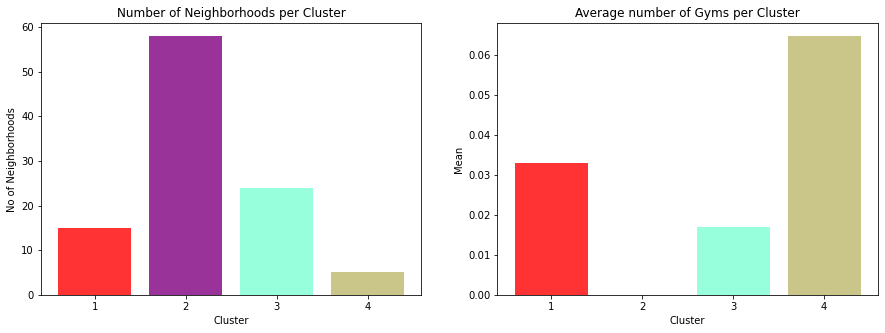

In [40]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = gym['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Gyms per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Gym'].mean(),df_cluster2['Gym'].mean(),df_cluster3['Gym'].mean(),
                df_cluster4['Gym'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Gyms per Cluster')